# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Задача проекта: построить модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до **0.59**. *F1*-мера на тестовой выборке проверяется самостоятельно.

Дополнительно будем измерять *AUC-ROC*, сравнивая её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

В работе будем использовать три алгоритма классификации:
 - Логистическая регрессия
 - Дерево решений
 - Случайный лес

*Работа изначально выполнялась на компьютере со свежими версиями библиотек, в частности scikit-learn.
Если не выполняется код, нужно запустить закоментированную ячейку ниже и перезагрузить ядро*

In [1]:
#!pip install -U scikit-learn

**Импорт библиотек**

In [2]:
#Обработка
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
pd.set_option('precision', 3)

#графики
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
cm = sns.light_palette("k", as_cmap=True)

#Обучение
#доп. обработка
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

#метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay


#алгоритмы
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#прочее
from sklearn.dummy import DummyClassifier
import pprint
pp = pprint.PrettyPrinter(indent=4)

## Подготовка данных

In [3]:
try:
    raw_data = pd.read_csv('/datasets/Churn.csv')
except:
    raw_data = pd.read_csv('Churn.csv')
churn = raw_data.copy()
display(churn.head())
display(churn.info())
display(churn.isna().sum())
display(churn.describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000,1.000e+04,10000.000,10000.000,9091.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,5000.500,1.569e+07,650.529,38.922,4.998,76485.889,1.530,0.706,0.515,100090.240,0.204
std,2886.896,7.194e+04,96.653,10.488,2.895,62397.405,0.582,0.456,0.500,57510.493,0.403
min,1.000,1.557e+07,350.000,18.000,0.000,0.000,1.000,0.000,0.000,11.580,0.000
1%,100.990,1.557e+07,432.000,21.000,0.000,0.000,1.000,0.000,0.000,1842.825,0.000
5%,500.950,1.558e+07,489.000,25.000,1.000,0.000,1.000,0.000,0.000,9851.819,0.000
10%,1000.900,1.559e+07,521.000,27.000,1.000,0.000,1.000,0.000,0.000,20273.580,0.000
25%,2500.750,1.563e+07,584.000,32.000,2.000,0.000,1.000,0.000,0.000,51002.110,0.000
50%,5000.500,1.569e+07,652.000,37.000,5.000,97198.540,1.000,1.000,1.000,100193.915,0.000
75%,7500.250,1.575e+07,718.000,44.000,7.000,127644.240,2.000,1.000,1.000,149388.247,0.000


 - достаточно много пропусков в столбце Tenure, проверим какие значения присутствуют в столбце и решим как лучше убрать пропуски
 - Столбцы RowNumber, CustomerId, Surname - не содержат полезной для решения задачи информации - можно удалить
 - Столбцы Age, CreditScore, Balance, EstimatedSalary следует стандартизировать для более адекватной работы алгоритмов машинного обучения
 - Столбцы Geography и Gender следует представить в числовом формате путём кодировки. 

Преобразуем пропуски

Text(0.5, 1.0, 'Распределение значений столбца Tenure')

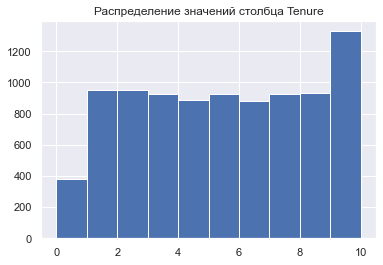

In [4]:
churn.Tenure.hist()
plt.title('Распределение значений столбца Tenure')

In [5]:
round(churn.corr()[4:5], 2)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Tenure,-0.01,-0.02,-0.0,-0.01,1.0,-0.01,0.01,0.03,-0.03,0.01,-0.02


Значения столбца Tenure распределены почти равномерно, сравнительно мало клиентов без недвижимости, и сравнительно много с 10-ю объектами. 
Нет значимых значений корреляции ни с одним из остальных признаков.<br>

<br>Заполнение средним значением или нулём внесёт значительный перекос в распределение
<br>Но, в зависимости от способа сбора информации, возможны варианты, когда клиент без недвижимости просто оставлял поле пустым


На этом этапе нужно было бы обратиться к поставщику данных за уточнением, но сейчас это невозможно. Поэтому неполные данные обозначим за *-1* считая это неуказанным значением, предполагая, что отсутствие информации тоже может быть информацией

*Примечание: на kaggle данный набор размещён без пропущенных значений и распределение имеет приблизительно такой же вид, то есть, скорее, всего случайным образом убрали значения. В таком случае было бы корректно так же случайным образом заполнить образовавшиеся пустоты, но в дальнейшем действую будто мне это не известно*

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Хм, я все же больше склоняюсь к варианту, что пропуск означает отсутствие недвижимости
</div>

In [6]:
churn['Tenure'] = churn['Tenure'].fillna(-1)

Удаляем ненужные столбцы

In [7]:
churn = churn.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

Кодируем категориальные признаки

In [8]:
churn.Geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [9]:
churn.Gender.unique()

array(['Female', 'Male'], dtype=object)

Порядковыми данные признаки не являются, поэтому будем использовать One-hot-encoding

In [10]:
churn = pd.get_dummies(churn, drop_first=True)

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Верное решение, молодец, что не забыл параметр drop_first
</div>

## Исследование задачи

### Разделение и дополнительная обработка данных

Целевой признак принимает значения 0 и 1 - перед нами стоит задача классификации
<br> За входные признаки обозначим все остальные, оставшиеся после обработки, и разделим их на три части для обучения, валидации и тестирования моделей соотношением 60/20/20

In [11]:
X = churn.drop(['Exited'], axis = 1)
Y = churn.Exited

Зафиксируем *random_state* в переменной для последующего использования

In [12]:
random_state = 42

In [13]:
#выделяем 70 процентов данных под тренировочную выборку
x_train, x_valid, y_train, y_valid = train_test_split(X,
                                                    Y,
                                                    train_size=0.6,
                                                    random_state=random_state, 
                                                    stratify=Y)
#оставшиеся 30% делим пополам на валидационную и тестовую выборки
x_valid, x_test, y_valid, y_test = train_test_split(x_valid,
                                                    y_valid,
                                                    train_size=0.5,
                                                    random_state=random_state, 
                                                    stratify=y_valid)

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Круто, что не забыл про параметр startify, лайк!
</div>

Численные, не категориальные признаки следует стандартизировать

In [14]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(x_train[numeric])
for data in [x_train, x_valid, x_test]:
    data[numeric] = scaler.transform(data[numeric])
    display(data.head(2))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6851,-1.284,0.009,9.0,0.330,2,1,0,-0.084,1,0,0
7026,0.272,-1.140,-1.0,-1.221,2,0,1,0.264,0,0,0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8583,-0.620,-0.087,2.0,1.060,1,0,1,0.350,0,0,0
1924,0.168,0.487,8.0,0.739,1,1,1,-0.135,0,0,1


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9167,-0.454,-1.236,1.0,-1.221,1,1,0,-1.215,0,0,1
9387,-1.315,-0.661,1.0,1.101,1,0,0,1.537,0,0,1


Проверим, в каком соотношении представлены значения целевого признака в данных

In [15]:
for data in [y_train, y_valid, y_test]:
    display(data.value_counts(normalize = 1))

0    0.796
1    0.204
Name: Exited, dtype: float64

0    0.796
1    0.204
Name: Exited, dtype: float64

0    0.796
1    0.203
Name: Exited, dtype: float64

Соотношение примерно одинаковое во всех выборках, что хорошо, но оно составляет около 80/20. Сильный дисбаланс может вызвать проблемы с точностью моделей

### Тестирование моделей

Для тестирования создадим функцию, которая будет обучать выбранные модели со стандартными гиперпараметрами и выводить матрицы ошибок и показатели по основным метрикам:
- ROC-AUC
- Точность
- Полнота
- F1-мера
- Accuracy

In [16]:
def train_score_models(features_train, target_train, features_valid, target_valid, balancing):
    
    models = {'Decision Tree': DecisionTreeClassifier(random_state=random_state,
                                                      class_weight=balancing), 
              'Random Forest': RandomForestClassifier(random_state=random_state,
                                                      class_weight=balancing),
              'Logistic Regression': LogisticRegression(random_state=random_state,
                                                        class_weight=balancing)}
    model_scores = {}
    confusion = []
    
    for model in models:
        scores = {}
        clf = models[model]
        clf.fit(features_train, target_train)
        prediction = clf.predict(features_valid)
        
        scores['Accuracy'] = accuracy_score(target_valid, prediction)
        confusion.append(confusion_matrix(target_valid, prediction, normalize = 'true'))
        scores['F1-score'] = f1_score(target_valid, prediction)
        scores['Precision'] = precision_score(target_valid, prediction)
        scores['Recall'] = recall_score(target_valid, prediction)
        scores['ROC-AUC'] = roc_auc_score(target_valid, prediction)
        model_scores[model]=scores
    scoring_table = pd.DataFrame(model_scores)
    
    plt.rcParams['axes.grid'] = False   
    
    fig = plt.figure(figsize=(15, 5))
    plt.tight_layout(pad=1)
    for i in range(1, 4):
        ax = fig.add_subplot(2, 3, i)
        ConfusionMatrixDisplay(confusion[i-1]).plot(ax =ax)
        ax.set_title(scoring_table.T.index[i-1])
    plt.suptitle('Матрицы ошибок')
    
    plt.show()
    plt.rcParams['axes.grid'] = True
    
    display(scoring_table.T)
    return scoring_table.T

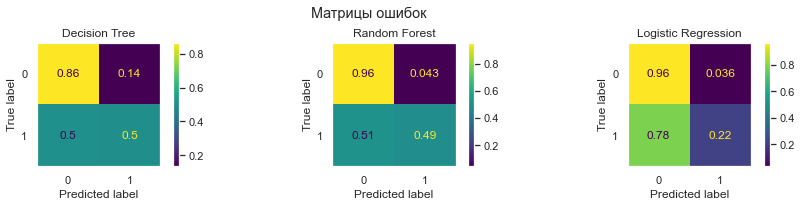

,Accuracy,F1-score,Precision,Recall,ROC-AUC
Decision Tree,0.789,0.491,0.484,0.498,0.681
Random Forest,0.862,0.593,0.744,0.493,0.725
Logistic Regression,0.812,0.324,0.612,0.221,0.592


In [17]:
scoring_table_unbalanced = train_score_models(x_train, y_train, x_valid, y_valid, None)

Сравним долю верных ответов с показаниями, которые даёт "неадекватная" модель

In [18]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)

dummy_clf.predict(x_valid)
dummy_clf.score(x_valid, y_valid)

0.796

Результаты моделей в этом плане почти не отличаются от модели, которая во всех случаях выдаёт 0. Случайный лес чуть более адекватнее остальных моделей. F1-мера сходу чуть больше требуемых 0.59
Посмотрим, как изменятся значения при применении методик борьбы с дисбалансом

## Борьба с дисбалансом

### Взвешивание классов при инициализации и обучении моделей (*weight_class = 'balanced'*)

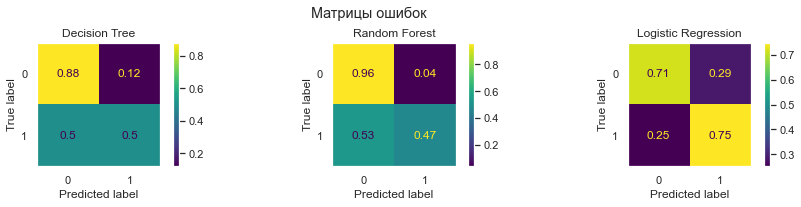

,Accuracy,F1-score,Precision,Recall,ROC-AUC
Decision Tree,0.801,0.507,0.514,0.500,0.689
Random Forest,0.860,0.577,0.752,0.468,0.714
Logistic Regression,0.720,0.521,0.400,0.748,0.730


In [19]:
scoring_table_balanced = train_score_models(x_train, y_train, x_valid, y_valid, 'balanced')

Для сравнения выведем снова прошлые результаты

In [20]:
scoring_table_unbalanced

,Accuracy,F1-score,Precision,Recall,ROC-AUC
Decision Tree,0.789,0.491,0.484,0.498,0.681
Random Forest,0.862,0.593,0.744,0.493,0.725
Logistic Regression,0.812,0.324,0.612,0.221,0.592


Для логистической регрессии значительно возросли F1-мера, полнота и ROC-AUC, при этом упала точность 
<br>
На дерево решений и случайный лес данный гиперпараметр влияет не так сильно, но результаты немного хуже
<br>

<br>
Ни одна из моделей не проходит отбор по критерию F1-меры

### Увеличение / уменьшение присутствия целевого признака и соответствующих признаков (upsampling/downsampling)

Для внесения баланса в данные попробуем:
 - увеличить присутствие в них целевого признака с положительным значением
 - уменьшить присутствие целевого признака с отрицательным значением

In [21]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled,
        target_upsampled,
        random_state=2411)
    
    return features_upsampled, target_upsampled

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled,
        target_downsampled,
        random_state=2411)
    
    return features_downsampled, target_downsampled

x_train_upsampled, y_train_upsampled = upsample(x_train, y_train, 4)
display(y_train_upsampled.value_counts(normalize = 1))

x_train_downsampled, y_train_downsampled = downsample(x_train, y_train, 0.25)
display(y_train_downsampled.value_counts(normalize = 1))

1    0.506
0    0.494
Name: Exited, dtype: float64

1    0.506
0    0.494
Name: Exited, dtype: float64

Снова проведём простую проверку трёх моделей, но обученных на сбалансированных данных

#### Сбалансированные данные - увеличено число значений 1

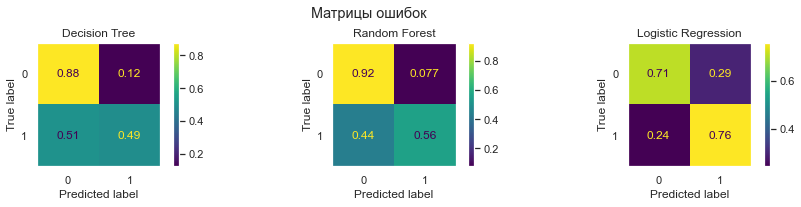

,Accuracy,F1-score,Precision,Recall,ROC-AUC
Decision Tree,0.798,0.499,0.506,0.493,0.685
Random Forest,0.850,0.603,0.652,0.561,0.742
Logistic Regression,0.716,0.521,0.397,0.757,0.731


In [22]:
balanced_comparison_upsampled = train_score_models(x_train_upsampled, y_train_upsampled, x_valid, y_valid, None)

#### Сбалансированные данные - уменьшено число значений 0

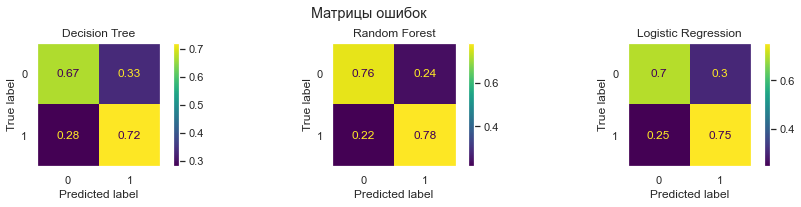

,Accuracy,F1-score,Precision,Recall,ROC-AUC
Decision Tree,0.678,0.478,0.357,0.721,0.694
Random Forest,0.765,0.576,0.456,0.782,0.772
Logistic Regression,0.710,0.515,0.390,0.755,0.726


In [23]:
balanced_comparison_downsampled = train_score_models(x_train_downsampled, y_train_downsampled, x_valid, y_valid, None)

Лучший результат показывает случайный лес при балансировке данных путём увеличения присутствия целевого признака с положительным значением
<br>**F1-мера** на валидационной выборке - **0.603**
<br>Но, у модели, обученной на downsampled-выборке больше полнота. Выбрав эту модель, попытки маркетологов сохранить клиентов будут захватывать б*о*льшую часть уходящих клиентов и довольно значимую долю тех, кто уходить не собирался. При выборе первой модели мы захватываем чуть меньше половины уходящих клиентов, но почти не тратимся на лояльных клиентов.

Зная примерную стоимость удержания клиента, можно было бы оценить выгодность использования моделей.

В данном случае выберем ту, у которой больше F1-мера и будем использовать upsampled-выборку



## Подбор гиперпараметров модели

В дальнейшем, будем работать с алгоритмом Случайного Леса и попробуем подобрать гиперпараметры так, чтобы улучшить имеющийся результат
Подберём число деревьев и их максимальную глубину

In [24]:
best_score = 0
best_num_est = 0
best_depth = 0
best_model = None

for num_est in range(100, 500, 100):
    for depth in range(5, 16, 1):
        model = RandomForestClassifier(max_depth=depth, n_estimators = num_est, random_state=2411, max_features='sqrt' )
        model.fit(x_train_upsampled, y_train_upsampled)
        predictions = model.predict(x_valid)
        score = f1_score(y_valid, predictions)
        if score > best_score:
            best_num_est = num_est
            best_depth = depth
            best_score = score
            best_model = model
        
print('Наибольшее значение F1 на валидационной выборке:', best_score,
     '\nДостигается при числе деревьев:', best_num_est, 'и максимальной глубине дерева:', best_depth)


Наибольшее значение F1 на валидационной выборке: 0.632967032967033 
Достигается при числе деревьев: 100 и максимальной глубине дерева: 11


Выведем остальные значения метрик по данной модели

In [25]:
forest_prediction = best_model.predict(x_valid)
    # Доля верных ответов
score_forest = best_model.score(x_valid, y_valid)
    # Матрица ошибок
cm_forest = confusion_matrix(y_valid, forest_prediction, normalize='true')
    # Рассчёты для ROC-AUC
y_score_forest = best_model.predict_proba(x_valid)
    # ROC-AUC
fpr_forest, tpr_forest, _ = roc_curve(y_valid, y_score_forest[:,1], pos_label=best_model.classes_[1])
    # Точность - полнота
prec_forest, recall_forest, _ = precision_recall_curve(y_valid, y_score_forest[:,1], pos_label=best_model.classes_[1])
# вывод в таблицу
models_scores = pd.DataFrame(
        {
         'Доля верных ответов':score_forest,
        'F1-score': f1_score(y_valid, forest_prediction),
         'Полнота': recall_score(y_valid, forest_prediction),
         'Точность':precision_score(y_valid, forest_prediction),
         'ROC-AUC':roc_auc_score(y_valid, forest_prediction)
        }, columns = ['Доля верных ответов', 'F1-score', 'Полнота', 'Точность', 'ROC-AUC'], index = ['Показатели на валидационной выборке'])


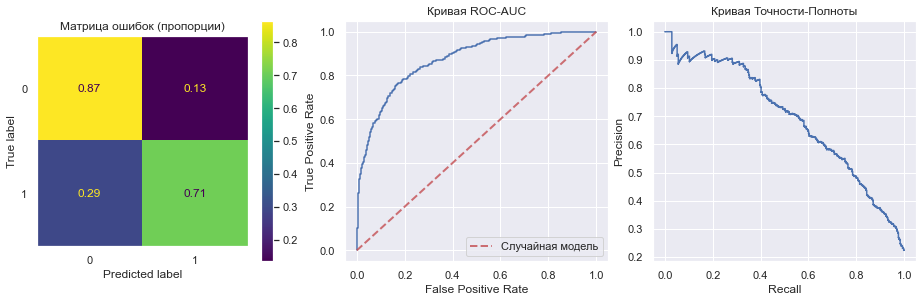

In [26]:
# вывод графиков
plt.rcParams['axes.grid'] = False
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(13, 4))
plt.tight_layout(pad= 1)

ConfusionMatrixDisplay(cm_forest).plot(ax = ax1)
ax1.set_title('Матрица ошибок (пропорции)')
    
RocCurveDisplay(fpr=fpr_forest, tpr=tpr_forest).plot(ax = ax2)
ax2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Случайная модель', alpha=.8)
ax2.set_title('Кривая ROC-AUC')
ax2.legend()
ax2.grid()

PrecisionRecallDisplay(precision=prec_forest, recall=recall_forest).plot(ax = ax3)
ax3.set_title('Кривая Точности-Полноты')
ax3.grid()

plt.show()

In [27]:
models_scores

,Доля верных ответов,F1-score,Полнота,Точность,ROC-AUC
Показатели на валидационной выборке,0.833,0.633,0.706,0.574,0.786


# 4. Тестирование модели

In [28]:
forest_prediction = best_model.predict(x_test)
    # Доля верных ответов 
score_forest = best_model.score(x_test, y_test)
    # Матрица ошибок
cm_forest = confusion_matrix(y_test, forest_prediction, normalize='true')
    # Рассчёты для ROC-AUC
y_score_forest = best_model.predict_proba(x_test)
    # ROC-AUC
fpr_forest, tpr_forest, _ = roc_curve(y_test, y_score_forest[:,1], pos_label=best_model.classes_[1])
    # Точность - полнота
prec_forest, recall_forest, _ = precision_recall_curve(y_test, y_score_forest[:,1], pos_label=best_model.classes_[1])

# вывод в таблицу
test_scores = pd.DataFrame(
        {
         'Доля верных ответов':score_forest,
        'F1-score': f1_score(y_test, forest_prediction),
         'Полнота': recall_score(y_test, forest_prediction),
         'Точность':precision_score(y_test, forest_prediction),
         'ROC-AUC':roc_auc_score(y_test, forest_prediction)
        }, columns = ['Доля верных ответов', 'F1-score', 'Полнота', 'Точность', 'ROC-AUC'], index = ['Показатели на тестовой выборке'])



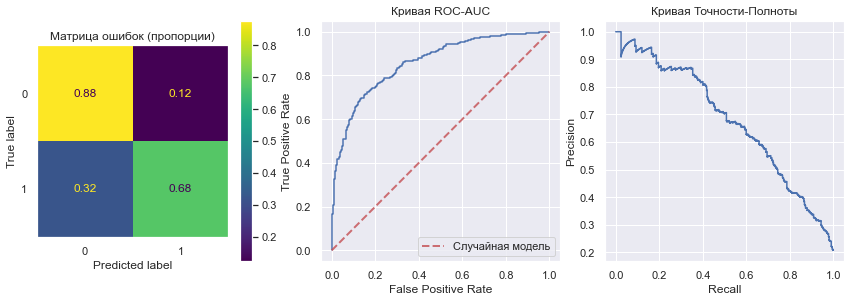

In [29]:
plt.rcParams['axes.grid'] = False

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 4))
plt.tight_layout(pad= 1)
ConfusionMatrixDisplay(cm_forest).plot(ax = ax1)
ax1.set_title('Матрица ошибок (пропорции)')
    

RocCurveDisplay(fpr=fpr_forest, tpr=tpr_forest).plot(ax = ax2)
ax2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Случайная модель', alpha=.8)
ax2.set_title('Кривая ROC-AUC')
ax2.legend()

ax2.set_title('Кривая ROC-AUC')
ax2.grid()
PrecisionRecallDisplay(precision=prec_forest, recall=recall_forest).plot(ax = ax3)
ax3.set_title('Кривая Точности-Полноты')
ax3.grid()

plt.show()

In [30]:
test_scores

,Доля верных ответов,F1-score,Полнота,Точность,ROC-AUC
Показатели на тестовой выборке,0.837,0.628,0.678,0.585,0.778


F1-мера больше 0.59 

## Вывод

Была проведена проверка трёх алгоритмов машинного обучения для решения задачи классификации клиентов:
- Логистическая регрессия
- Дерево решений
- Случайный лес<br>

Целевым признаком являлся столбец *Exited* - обозначающий уход клиента из банка
Основным критерием являлась F1-мера - учитывающая одновременно точность и полноту алгоритма, с пороговым значенем для прохождения теста **0.59**

<br>
В ходе анализа набора данных был выявлен значительный дисбаланс между отрицательными и положительными значениями целевого признака около 80/20
<br>Данные были поделены на тренировочную, тестовую и валидационную выборки в пропорции 60/20/20 с сохранением дисбаланса.

<br>Учёт данного фактора при инициализации моделей даёт значимый результат только для логистической регрессии, но не достаточный для преодоления порога отбора.
<br>Для устранения дисбаланса в данных для обучения были опробованы две методики - уменьшения и увеличения выборки. Формально лучший результат (значение меры F1 на валидационной выборке - **0.603**) был получен алогоритмом Случайного леса при увеличении выборки, с увеличением присутствия в ней положительных значений признака *Exited*

<br>Затем модель тестировалась на увеличенной выборке с различными значениями гиперпараметров:
- *n_estimators* - число деревьев в лесу
- *max_depth* - максимальная глубина дерева
<br>

Лучший результат был достигнут при значениях *n_estimators=100*, *max_depth=11* - F1-мера = **0.633** на валидационной выборке и **0.628** на тестовой, с показателем ROC-AUC **0.786** и **0.778** соответственно.
<br>Для модели, предсказывающей случайным образом, этот показатель равен 0.5. Поэтому, по этой метрике результат тоже хороший
<br> Доля правильных ответов составила **0.837**, полнота - **0.678**, точность - **0.585** - около 59% клиентов, определённых как ушедшие, действительно ушли, но правильно определено около 70% ушедших
